### **Wine Quality Prediction using ANN and MLFlow**

### 1. Import the required libraries

In [1]:
# import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import mlflow
from mlflow.models import infer_signature

In [8]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

### 2. Load the dataset

In [2]:
# load the data
# load the wine quality dataset from mlflow
dataset_source_url = "https://raw.githubusercontent.com/mlflow/mlflow/master/tests/datasets/winequality-white.csv"
raw_data = pd.read_csv(dataset_source_url, delimiter=";")

In [3]:
raw_data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


### 3. Train, validation, Test Split

In [4]:
# split the data into training, validation and test datasets
train, test = train_test_split(raw_data, test_size=0.25, random_state=42)

In [5]:
# print shape of the train and test data
print("train shape: ", train.shape)
print("test shape: ", test.shape)

train shape:  (3673, 12)
test shape:  (1225, 12)


In [6]:
# split the train data into training and validation datasets
train_X = train.drop("quality", axis=1).values
train_y = train["quality"].values.ravel()

X_train, X_val, y_train, y_val = train_test_split(train_X, train_y, test_size=0.20, random_state=42)

# test data
X_test = test.drop("quality", axis=1).values
y_test = test["quality"].values.ravel()

# print shape of the train, validation and test data
print("Training data shape: ", X_train.shape)
print("Validation data shape: ", X_val.shape)
print("Testing data shape: ", X_test.shape)

Training data shape:  (2938, 11)
Validation data shape:  (735, 11)
Testing data shape:  (1225, 11)


### 4. Exploratory data analysis (EDA)

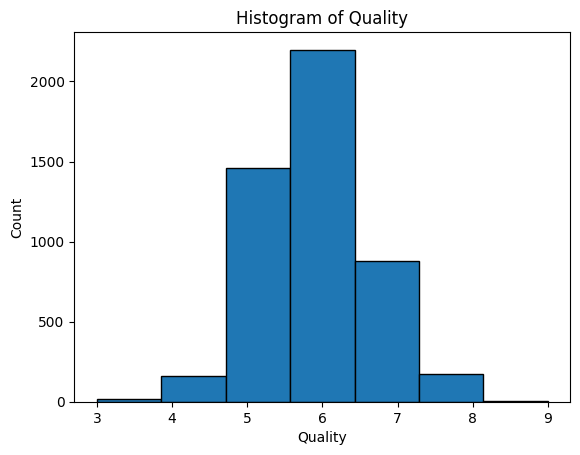

In [26]:
# histogram of the target variable
plt.hist(raw_data['quality'], bins=7, edgecolor='black')
plt.xlabel('Quality')
plt.ylabel('Count')
plt.title('Histogram of Quality')
plt.show()

In [27]:
# describe the raw data
raw_data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


In [28]:
# data types of the raw data
raw_data.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

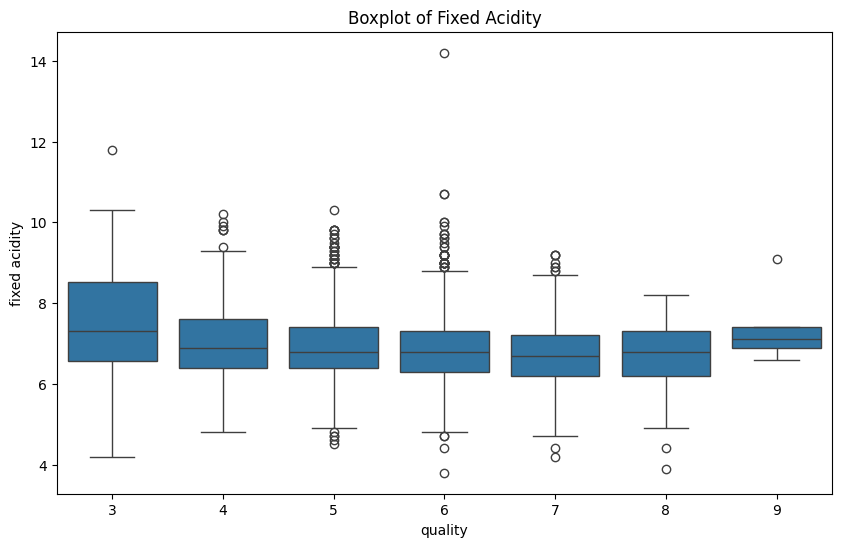

In [30]:
# boxplot of the raw data
# fixed acidity
plt.figure(figsize=(10, 6))
sns.boxplot(x='quality', y='fixed acidity', data=raw_data)
plt.title('Boxplot of Fixed Acidity')
plt.show()

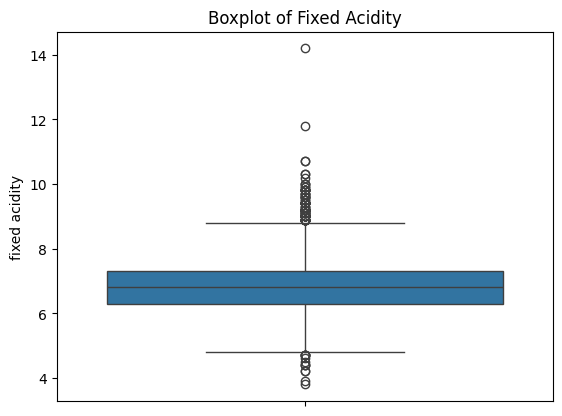

In [32]:
# fixed acidity
sns.boxplot(data=raw_data['fixed acidity'])
plt.title('Boxplot of Fixed Acidity')
plt.show()

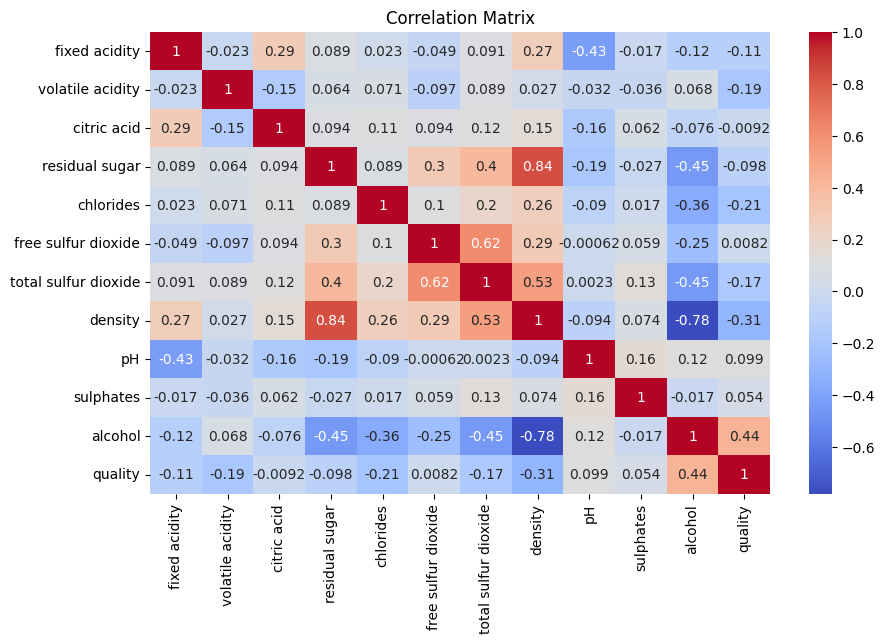

In [33]:
# correlation matrix
correlation_matrix = raw_data.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [7]:
# set the sugnataure
signature = infer_signature(X_train, y_train)

In [14]:
np.mean(X_train, axis=0)

array([6.86621852e+00, 2.80377808e-01, 3.32597005e-01, 6.42164738e+00,
       4.55513955e-02, 3.53556841e+01, 1.38792376e+02, 9.94074221e-01,
       3.18919333e+00, 4.88396869e-01, 1.05005673e+01])

In [13]:
np.var(X_train, axis=0)

array([7.27006361e-01, 1.04782780e-02, 1.41982590e-02, 2.63994276e+01,
       4.46194261e-04, 2.83726450e+02, 1.74920842e+03, 9.23159572e-06,
       2.25891723e-02, 1.24958983e-02, 1.49906782e+00])

### 5. Create, Train, and Log the model

In [19]:
# create a model
def train_model(params, epochs, X_train, y_train, X_val, y_val, X_test, y_test):
    mean = np.mean(X_train, axis=0)
    var = np.var(X_train, axis=0)

    model = keras.models.Sequential(
        [
           keras.Input([X_train.shape[1]]),
           keras.layers.Normalization(mean=mean, variance=var),
           keras.layers.Dense(64, activation="relu"),
           keras.layers.Dense(1),
        ]
    )

    # compile the model
    model.compile(optimizer=keras.optimizers.SGD(
        learning_rate=params["lr"],
        momentum=params["momentum"]
    ),
    loss="mean_squared_error",
    metrics=[keras.metrics.RootMeanSquaredError()]
    )

    # train the ANN model with lr and momentum parameters with MLFLow tracking
    with mlflow.start_run(nested=True):
        model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=64
        )

        # evaluate the model
        eval_result = model.evaluate(X_test, y_test, batch_size=64)

        eval_rmse = eval_result[1]

        # log the parameters
        mlflow.log_params(params)
        mlflow.log_params({"eval_rmse": eval_rmse})

        # log the model
        mlflow.tensorflow.log_model(model, "model", signature=signature)

        return {"loss": eval_rmse, "status": STATUS_OK, "model": model}

### 6. Objective function - Keep track of each run in MLFLOW

In [10]:
def objective(params):
    # MLFLow tracking, will track the paaraters and the results for each run
    result = train_model(
        params,
        epochs=3,
        X_train=X_train,
        y_train=y_train,
        X_val=X_val,
        y_val=y_val,
        X_test=X_test,
        y_test=y_test
    )
    return result

### 7. Define Hyperparameters

In [11]:
space={
    "lr":hp.loguniform("lr", np.log(1e-5), np.log(1e-1)),
    "momentum":hp.uniform("momentum", 0.0, 1.0)
}

### 8. MLFLOW Expereiment

In [20]:
mlflow.set_experiment("/wine-quality")
with mlflow.start_run():
   # conduct the hyperparameter search with hyperopt
    trials = Trials()
    best = fmin(
        fn=objective,
        space=space,
        algo=tpe.suggest,
        max_evals=4,
        trials=trials
    )

    # fetch details of the best run
    best_run = sorted(trials.results, key=lambda x: x["loss"])[0]

    # log the best run
    mlflow.log_params(best)
    mlflow.log_metric("eval_rmse", best_run["loss"])
    mlflow.tensorflow.log_model(best_run["model"], "best_model", signature=signature)

    # print the best parameters and corresponding loss
    print("best parameters: ", best)
    print("best loss: ", best_run["loss"])

Epoch 1/3                                            

 1/46 ━━━━━━━━━━━━━━━━━━━━ 44s 992ms/step - loss: 31.8023 - root_mean_squared_error: 5.6394
19/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 30.2501 - root_mean_squared_error: 5.4999   
35/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 29.9684 - root_mean_squared_error: 5.4742
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 29.6605 - root_mean_squared_error: 5.4458 - val_loss: 25.6209 - val_root_mean_squared_error: 5.0617

Epoch 2/3                                            

 1/46 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 26.2204 - root_mean_squared_error: 5.1206
26/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 24.5945 - root_mean_squared_error: 4.9589 
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 24.0349 - root_mean_squared_error: 4.9018 - val_loss: 20.1125 - val_root_mean_squared_error: 4.4847

Epoch 3/3                                            

 1/46 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 20.4151 - root_mean_squared_error: 4.

### 9. Inferencing the model - Take logged model and execute on test data

In [21]:
# Inferencing

from mlflow.models import validate_serving_input

model_uri = 'runs:/f39a8fef8d88498897d99d51d88e826d/model'

# The logged model does not contain an input_example.
# Manually generate a serving payload to verify your model prior to deployment.
from mlflow.models import convert_input_example_to_serving_input

# A valid input example is a data instance suitable for pyfunc prediction
serving_payload = convert_input_example_to_serving_input(X_test)

# Validate the serving payload works on the model
validate_serving_input(model_uri, serving_payload)

e:\MLOps\MLFlow\venvmlops\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


array([[6.027805 ],
       [7.3751807],
       [6.886912 ],
       ...,
       [6.716262 ],
       [7.213863 ],
       [6.328612 ]], dtype=float32)

### 10. Loading the model as Python Function

In [22]:
# Load the model in `python_function` format
loaded_model = mlflow.pyfunc.load_model(model_uri)

# Predict on the test data
loaded_model.predict(pd.DataFrame(X_test))

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


array([[6.027805 ],
       [7.3751807],
       [6.886912 ],
       ...,
       [6.716262 ],
       [7.213863 ],
       [6.328612 ]], dtype=float32)

### 11. Register the best model

In [23]:
# Register the model manually
model_name = "wine-quality-model"
mlflow.register_model(model_uri, model_name)

Successfully registered model 'wine-quality-model'.
Created version '1' of model 'wine-quality-model'.


<ModelVersion: aliases=[], creation_timestamp=1735946396065, current_stage='None', description=None, last_updated_timestamp=1735946396065, name='wine-quality-model', run_id='f39a8fef8d88498897d99d51d88e826d', run_link=None, source='file:///e:/MLOps/MLFlow/Wine%20Quality%20Prediction/mlruns/932046367553316098/f39a8fef8d88498897d99d51d88e826d/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=1>